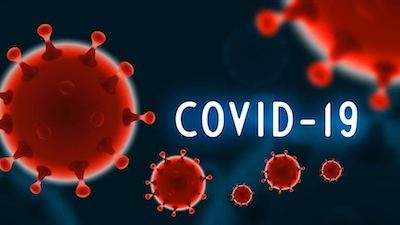

**Project: Detect Coronavirus From CT-Scan image**

**Date: Summer 2022**

**Developers:**


1.   Maedeh Mirzazadeh (@maedemir on [github](https://github.com/maedemir))
2.   Seyed Nami Modarressi (@SNamiMod on [github](https://github.com/SNamiMod))



# Step1: Loading and Visualizing the Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import cv2
import seaborn as sns
import numpy as np
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_dataset(path):
  dataset = []
  counter = 0
  number_of_data = len(os.listdir(path))
  for dir in sorted(os.listdir(path)):   # ploting first 10 images of the non-covid data
    if counter == 1200:
      break
    imgPath = os.path.join(path, dir) 
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)  # saving images as RGB
    dataset.append(img)
    counter += 1
  return number_of_data, dataset

In [4]:
def plot_dataset(dataset, num):
  counter = 0
  plt.figure(figsize = (5, 10)) # width = 5 inches and heighty = 10 inches
  for i, img in enumerate(dataset[:num]):
    ax = plt.subplot(5, 2, counter+1)
    plt.title(i+1)
    plt.imshow(img, cmap='gray', aspect = 'auto')
    plt.axis('off')
    counter += 1
  plt.subplots_adjust(hspace = 0.5, wspace = 0.1)  # hspace = vertical distance between images
  plt.show()                                       # wspace = horizental distance between images
  

## Let's see some samples of corona positive dataset

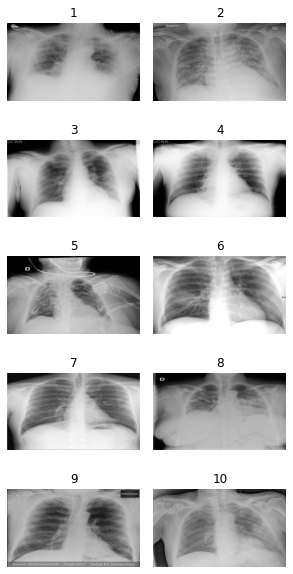

In [5]:
covid_positive_path = '/content/drive/MyDrive/CXR_IMAGES/CXR_COVID' # Path of covid positive folder
cp_num, covid_positive_data = load_dataset(covid_positive_path)
plot_dataset(covid_positive_data, 10)

## and now some examples of corona negative dataset

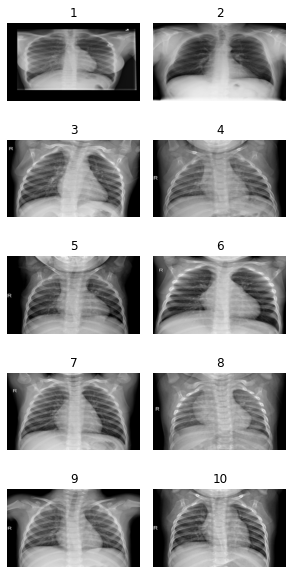

In [6]:
covid_negative_path = '/content/drive/MyDrive/CXR_IMAGES/CXR_NonCOVID' #Path of covid negative folder
cn_num, covid_negative_data = load_dataset(covid_negative_path)
plot_dataset(covid_negative_data, 10)

# Step2: Data Pre-Processing 


1.   Resizing all images
2.   Split data to train(data and label) and test(data and label) --> 80% train , 20% test
3.   Normalization
4.   Data Augmentation

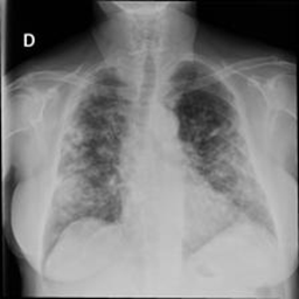

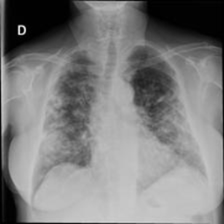

In [7]:
# resizing images
def resize(dataset):
  dim = (224, 224)   # VGG16 takes input tensor size as 224, 244 with 3 RGB channel
  result = []
  for im in dataset:
    result.append(cv2.resize(im, dim))
  return result

from google.colab.patches import cv2_imshow
cv2_imshow(covid_positive_data[10])
covid_positive_data = resize(covid_positive_data)
covid_negative_data = resize(covid_negative_data)
cv2_imshow(covid_positive_data[10])


In [8]:
# Split data to train, test

all_data = covid_positive_data + covid_negative_data

# label for positive corona = 1 , label for negative corona = 0
all_labels = [1] * len(covid_positive_data) + [0] * len(covid_negative_data)

all_data = np.array(all_data)/255

# splitting data to train and test(both labels and data)
x_train, x_test, y_train, y_test = train_test_split(all_data, all_labels, train_size = .8)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(1920, 224, 224, 3)
(1920, 2)
(480, 224, 224, 3)
(480, 2)


In [9]:
#  Data Augmentation
datagenerator = ImageDataGenerator(rotation_range=20,  # rotation
                                   width_shift_range=0.2,  # horizontal shift
                                   height_shift_range=0.2,  # vertical shift
                                   horizontal_flip=True  # horizontal flip
                                    )

# Step3: Buliding & Training our Model

In [10]:
VGG19_base_model = tf.keras.applications.VGG19(weights = 'imagenet',
                                         include_top = False,
                                         input_shape = (224,224,3))
for layer in VGG19_base_model.layers:
  layer.trainable = False

VGG19_base_model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

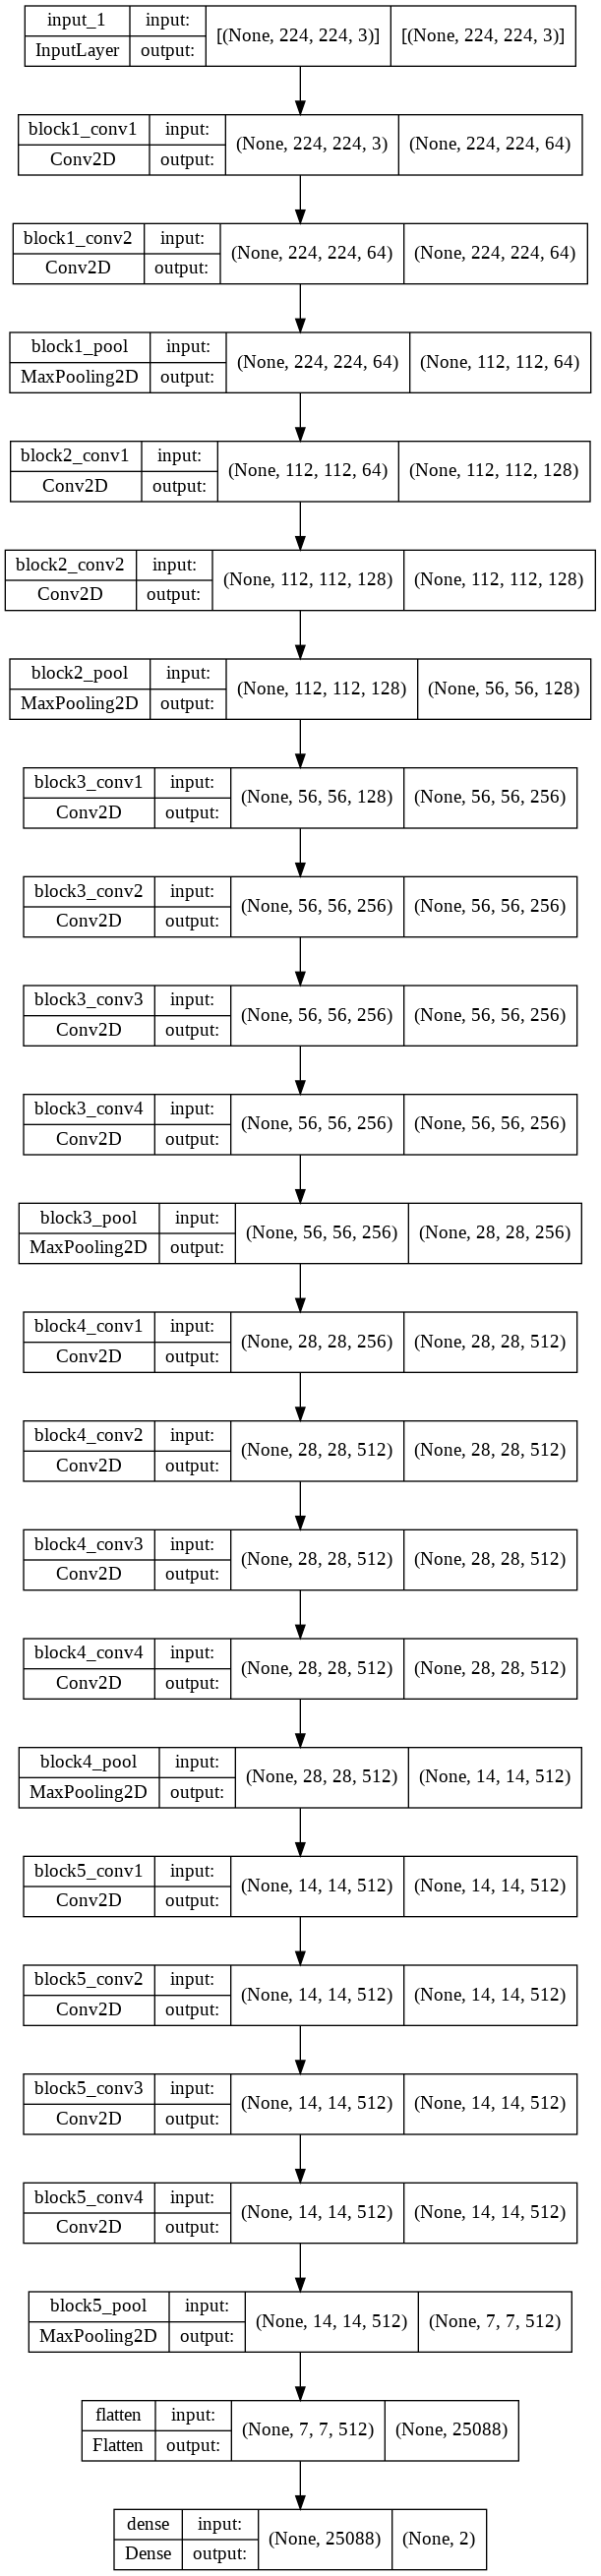

In [11]:
outputs = VGG19_base_model.output
outputs = Flatten(name = "flatten")(outputs)
outputs = Dense(2, activation="softmax")(outputs)
final_model = Model(inputs = VGG19_base_model.input, outputs = outputs)

adam =  tf.keras.optimizers.Adam()
final_model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                    metrics=['accuracy'])
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# Fit
batch_size1 = 32
epochs1 = 20
history = final_model.fit(datagenerator.flow(x_train, y_train, batch_size= batch_size1),
                    validation_data=(x_test, y_test),
                    validation_steps=len(x_test) / batch_size1,
                    steps_per_epoch=len(x_train) / batch_size1,
                    epochs= epochs1)

Epoch 1/20
60/60 [==============================] - 45s 511ms/step - loss: 0.4702 - accuracy: 0.7854 - val_loss: 0.3824 - val_accuracy: 0.8229
Epoch 2/20
60/60 [==============================] - 29s 486ms/step - loss: 0.3484 - accuracy: 0.8568 - val_loss: 0.2788 - val_accuracy: 0.8771
Epoch 3/20
60/60 [==============================] - 32s 530ms/step - loss: 0.3181 - accuracy: 0.8714 - val_loss: 0.5115 - val_accuracy: 0.7583
Epoch 4/20
60/60 [==============================] - 29s 483ms/step - loss: 0.3252 - accuracy: 0.8635 - val_loss: 0.2214 - val_accuracy: 0.9083
Epoch 5/20
60/60 [==============================] - 28s 471ms/step - loss: 0.2758 - accuracy: 0.8875 - val_loss: 0.1973 - val_accuracy: 0.9125
Epoch 6/20
60/60 [==============================] - 29s 484ms/step - loss: 0.2698 - accuracy: 0.8974 - val_loss: 0.2193 - val_accuracy: 0.9229
Epoch 7/20
60/60 [==============================] - 29s 480ms/step - loss: 0.2601 - accuracy: 0.8917 - val_loss: 0.1939 - val_accuracy: 0.9146

# Step4: Save and Evaluate the model

In [13]:
final_model.evaluate(x_test, y_test, batch_size1)

15/15 [==============================] - 3s 201ms/step - loss: 0.1515 - accuracy: 0.9312


[0.15153421461582184, 0.9312499761581421]

In [14]:
# Prediction
y_prediction = final_model.predict(x_test, batch_size=batch_size1)

# Convert to Binary classes
binary_y_test= np.argmax(y_test, axis=1)
binary_y_prediction = np.argmax(y_prediction, axis=1)

# Classification reports
print(classification_report(binary_y_test, binary_y_prediction))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       228
           1       0.92      0.95      0.94       252

    accuracy                           0.93       480
   macro avg       0.93      0.93      0.93       480
weighted avg       0.93      0.93      0.93       480



In [15]:
final_model.save('/content/drive/MyDrive/CXR_IMAGES/VGG19_CXR_model.h5')
final_model.save_weights('/content/drive/MyDrive/CXR_IMAGES/VGG19_CXR_model_wights.h5')

In [16]:
# loading our model
trained_model = load_model('/content/drive/MyDrive/CXR_IMAGES/VGG19_CXR_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


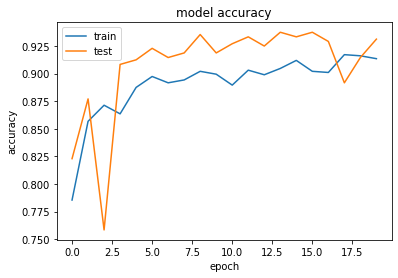

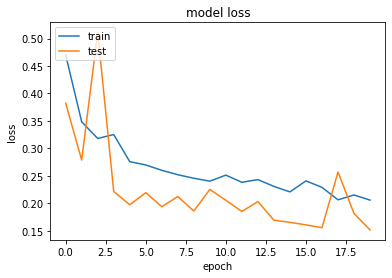

In [17]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
print()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

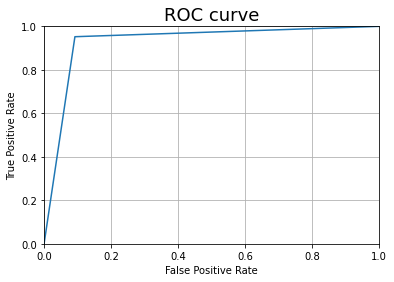

In [18]:
fpr, tpr, thresholds_keras = roc_curve(binary_y_test, binary_y_prediction)
auc_keras = auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.rcParams['font.size'] = 15
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.grid(True)

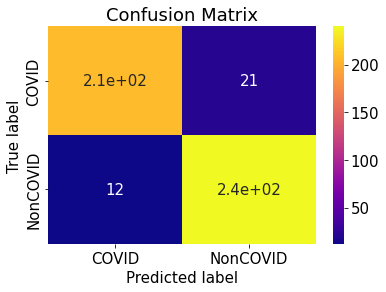

Confusion Matrix without Normalization


In [19]:
classes = ['COVID','NonCOVID']
tick_marks = [0.5,1.5]
confusionMatrix = confusion_matrix(binary_y_test, binary_y_prediction, normalize=None)
sns.heatmap(confusionMatrix, cmap='plasma',annot=True)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print('Confusion Matrix without Normalization')

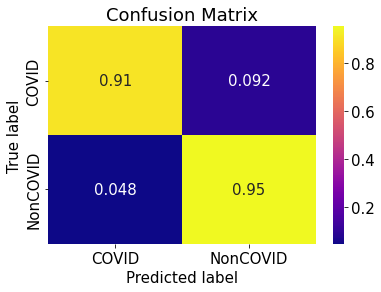

Confusion Matrix with Normalized Values


In [20]:
classes = ['COVID','NonCOVID']
tick_marks = [0.5,1.5]
confusionMatrix = confusion_matrix(binary_y_test, binary_y_prediction, normalize='true')
sns.heatmap(confusionMatrix, cmap='plasma',annot=True)
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print('Confusion Matrix with Normalized Values')